# Downloading and plotting data
In this demo we aim to download some public data, read it in  then plot it. This aims to demonstrate some of the key data processing steps needed for data science. In this case we will be plotting temperature climatology data from the AIMS logger program. The [Temperature Loggers Climatology For The GBR Region (NESP TWQ 4.2, AIMS)](https://apps.aims.gov.au/metadata/view/75c9c4a9-f37f-45a6-9532-053506b43bd9) dataset provides climatology temperature conditions for each day of the year for sites where there is 10 or more years of logger data. The climatology is where the data for a given day of the year is combined with all the other years on the same day of the year, giving an estimate as to what is typical for that time of the year.

In this script we will:
1. Download the data from the AIMS website. This saves having to store the data directly in the repository.
2. Unpack the zip file.
3. Load some of the CSV files. 
4. Plot the results.

## Downloading the data using Bash
From a Jupyter notebook we can directly call command line tools and so we can download the data using wget. wget is a very mature tool and probably a better solution than downloading using Julia. Maybe later I will work out how to do it directly in Julia. We can rely on the wget tool being available as we are running the Jupyter notebook in a Docker container that is running a Linux operating system. Thus command line environment for the Jupyter notebook is  Linux, even if Docker is running on a Windows machine.

### Running command line tools using Julia within Jupyter
If you have previously used Jupyter notebooks for Python then you would know that you can call command line scripts directly within the notebook by prepending the script with ! or %%bash. Unfortunately these cause an issue with Julia because ! is valid Julia and so not a suitable string to indicate that the code is for the command line. 

We can however create a short Julia macro that allows us to achieve the same effect. This was suggested by IJulia when I tried to use the %%bash method.

In [14]:
macro bash_str(s) open(`bash`,"w",stdout) do io; print(io, s); end; end

@bash_str (macro with 1 method)

Now we need to download the data to the data folder and unzip it. Here we use the --no-clobber option so that if the data is already downloaded then it will not redownload again. This speeds up subsequent reruns. We also make the unzip output directory if it doesn't exist. We also use the unzip -n option in unzip to skip extractions if they already exist, again to speed up reruns.

In [15]:
bash"""
wget --no-clobber -O temp/Climatology_csv.zip https://s3-ap-southeast-2.amazonaws.com/aims-static-apps/data/75c9c4a9-f37f-45a6-9532-053506b43bd9/Climatology_csv.zip
mkdir -p temp/Climatology_csv
unzip -n temp/Climatology_csv.zip -d temp/Climatology_csv
"""

Archive:  temp/Climatology_csv.zip


File ‘temp/Climatology_csv.zip’ already there; not retrieving.


As well as the above technique I just found out that you can call shell commands by starting the cell with semicolon (;), however it only seems to work if there is a single command per notebook cell. The same as above can be achieved with the following:

In [16]:
;wget --no-clobber -O temp/Climatology_csv.zip https://s3-ap-southeast-2.amazonaws.com/aims-static-apps/data/75c9c4a9-f37f-45a6-9532-053506b43bd9/Climatology_csv.zip

File ‘temp/Climatology_csv.zip’ already there; not retrieving.


In [17]:
;mkdir -p temp/Climatology_csv

In [18]:
;unzip -n temp/Climatology_csv.zip -d temp/Climatology_csv

Archive:  temp/Climatology_csv.zip


Now we have our data we will want to read in some sample data.
## Reading in CSV data

For doing the data loading and processing we will be using the [CSV](https://github.com/JuliaData/CSV.jl) and [DataFrames](https://juliadata.github.io/DataFrames.jl/stable/man/getting_started/#Installation) packages. These packages have not already been installed in this Docker container and so we need to install them here. This means that the first time you run this it will take a little time for the installation. Note: Each time Docker is restarted it forgets everything that was installed since it started because it restarts from the original Docker image. For packages that you use a lot, or are slow to install and compile it is worth adding them to the Dockerfile and rebuilding the Docker image.

In [19]:
using Pkg
Pkg.add("DataFrames")
Pkg.add("CSV")

   Updating registry at `/opt/julia/registries/General`
######################################################################### 100.0%
  Resolving package versions...
  Installed InvertedIndices ─── v1.0.0
  Installed PooledArrays ────── v0.5.3
  Installed StructTypes ─────── v1.1.0
  Installed CategoricalArrays ─ v0.8.2
  Installed DataFrames ──────── v0.21.7
Updating `/opt/julia/environments/v1.5/Project.toml`
  [a93c6f00] + DataFrames v0.21.7
Updating `/opt/julia/environments/v1.5/Manifest.toml`
  [324d7699] + CategoricalArrays v0.8.2
  [a93c6f00] + DataFrames v0.21.7
  [41ab1584] + InvertedIndices v1.0.0
  [2dfb63ee] + PooledArrays v0.5.3
  [856f2bd8] + StructTypes v1.1.0
  [9fa8497b] + Future
  Resolving package versions...
  Installed SentinelArrays ─ v1.2.15
  Installed CSV ──────────── v0.7.7
Updating `/opt/julia/environments/v1.5/Project.toml`
  [336ed68f] + CSV v0.7.7
Updating `/opt/julia/environments/v1.5/Manifest.toml`
  [336ed68f] + CSV v0.7.7
  [91c51154] + SentinelArra

In [20]:
using CSV
using DataFrames
tempdf_davies = DataFrame(CSV.File("temp/Climatology_csv/Davies_Reef_dayClimatology_SL.csv"))

┌ Info: Precompiling CSV [336ed68f-0bac-5ca0-87d4-7b16caf5d00b]
└ @ Base loading.jl:1278


,yDay,Temp.dmm,Temp.dmax,Temp.dmin,Temp.dsd,Temp.mad,Temp.q01,Temp.q003
,Int64,Float64,Float64,Float64,Float64,Float64,Float64,Float64
1,1,28.0986,29.6221,27.04,0.571661,0.582658,27.2455,27.2339
2,2,28.093,29.6109,27.012,0.575314,0.464177,27.2147,27.2136
3,3,28.107,29.9691,27.012,0.595394,0.557118,27.1047,27.096
4,4,28.1759,30.0587,26.9235,0.578001,0.524738,27.0789,27.0496
5,5,28.2378,29.6333,26.7545,0.601204,0.653867,27.0626,27.0052
6,6,28.3081,29.9131,26.692,0.615757,0.668373,27.0396,26.9883
7,7,28.3576,29.8571,26.906,0.609702,0.593131,27.1245,27.0877
8,8,28.4299,29.8124,27.012,0.604473,0.501128,27.1814,27.1504
9,9,28.4517,29.591,27.03,0.594333,0.294485,27.2074,27.167


As an exercise in using the DataFrames lets find which days of the year the maximum temperature is over 29 deg C. Here dot notation (.>) is used to indicate that the greater than operation is using [broadcasting](https://docs.julialang.org/en/v1/base/arrays/#Broadcast-and-vectorization) to apply the function to each of the elements in the array. 

In [21]:
hotdays = tempdf_davies[tempdf_davies."Temp.dmm" .> 28.5, :]
hotdays[1:5,:]

,yDay,Temp.dmm,Temp.dmax,Temp.dmin,Temp.dsd,Temp.mad,Temp.q01,Temp.q003
,Int64,Float64,Float64,Float64,Float64,Float64,Float64,Float64
1,30,28.5212,30.1035,27.4342,0.473474,0.368683,28.0441,28.0428
2,31,28.5291,29.9985,27.4968,0.502974,0.497374,27.8263,27.8152
3,32,28.6161,30.0555,27.5803,0.500506,0.424359,27.8512,27.8171
4,33,28.6394,29.952,27.6533,0.491602,0.435776,27.8531,27.8158
5,34,28.668,29.9011,27.7577,0.516495,0.561767,27.8884,27.8722


# Plotting the data
Now we have some data lets plot it. There is more detail in the official [Plots tutorial](https://docs.juliaplots.org/latest/tutorial/). The Plots package has been installed as part of the Docker container and precompiled. This was done because it takes about 5 mins to install and compile.

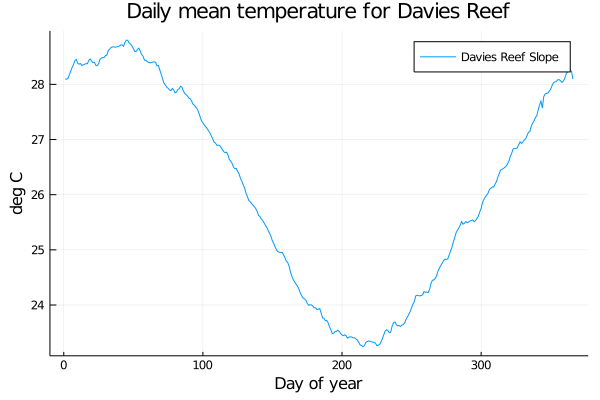

In [22]:
using Plots

# plot some data
p = plot(tempdf_davies."yDay", tempdf_davies."Temp.dmm", title = "Daily mean temperature for Davies Reef", 
    label = "Davies Reef Slope", xlabel="Day of year", ylabel="deg C")

Let us add a more southern reef to see if the climate is different.

The plot capabilities in Julia seem to be much simplier and less powerful than ggplot in R.

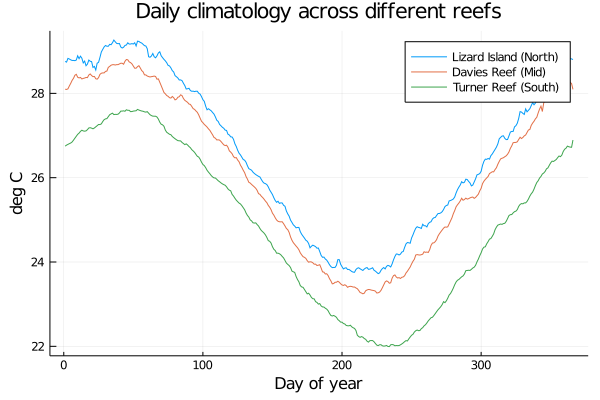

In [23]:
tempdf_turner = DataFrame(CSV.File("temp/Climatology_csv/Turner_Cay_dayClimatology_SL.csv"))
tempdf_lizard = DataFrame(CSV.File("temp/Climatology_csv/Lizard_Island_dayClimatology_SL.csv"))
p = plot(tempdf_lizard."yDay", tempdf_lizard."Temp.dmm", label="Lizard Island (North)")
plot!(p, tempdf_davies."yDay", tempdf_davies."Temp.dmm", label="Davies Reef (Mid)")
plot!(p, tempdf_turner."yDay", tempdf_turner."Temp.dmm", label="Turner Reef (South)",
    title = "Daily climatology across different reefs", 
    xlabel="Day of year", ylabel="deg C")
    